In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import folium
from folium import plugins
import datetime as dt
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter, YearLocator
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_file, show
from bokeh.models import Range1d
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh import embed

%matplotlib inline 
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

In [2]:
MESI = ['gen','feb','mar','apr','mag','giu','lug','ago','set','ott','nov','dic']

# Import data

In [3]:
df = pd.read_csv('data/incidenti_2007_2017.csv')

In [4]:
df = df[df['DataOraIncidente_year']!=2017].copy()

In [5]:
df.head()

,Chilometrica,CondizioneAtmosferica,Confermato,DaSpecificare,DataOraIncidente,FondoStradale,Gruppo,ID,Illuminazione,Latitudine,Localizzazione1,Localizzazione2,Longitudine,NUM_FERITI,NUM_ILLESI,NUM_MORTI,NUM_RISERVATA,NaturaIncidente,ParticolaritaStrade,Pavimentazione,Segnaletica,Strada02,Strada1,Strada2,TipoStrada,Traffico,Visibilita,DataOraIncidente_date,DataOraIncidente_time,DataOraIncidente_time_h,DataOraIncidente_weekday,DataOraIncidente_month,DataOraIncidente_year
0,151-153,Nuvoloso,1.0,NaN,2007-01-01 00:00:00,Asciutto,18,1707637,Sufficiente,NaN,Strada Urbana,in prossimità,NaN,0,0,0,0,Veicolo in marcia contro veicolo in sosta,Rettilineo,Asfaltata,Verticale ed orizzontale,del civico n.,VIA ANASTASIO II,NaN,Due carreggiate,Normale,Buona,2007-01-01,00:00:00,0,0,1,2007
1,537,Nuvoloso,1.0,NaN,2007-01-01 00:40:00,Asciutto,4,1708657,Sufficiente,NaN,Provinciale entro l'abitato,in prossimità,NaN,2,9,0,0,Tamponamento Multiplo,Rettilineo,Asfaltata,Verticale ed orizzontale,del civico n.,VIA NOMENTANA,NaN,Più di due carreggiate,Normale,Buona,2007-01-01,00:40:00,0,0,1,2007
2,123/A,Pioggia in atto,1.0,NaN,2007-01-01 01:10:00,Bagnato (pioggia),18,1707214,Sufficiente,NaN,Strada Urbana,in prossimità,NaN,1,2,0,0,Scontro frontale/laterale DX fra veicoli in ma...,Rettilineo,Asfaltata,Orizzontale,del civico n.,VIA MATTIA BATTISTINI,NaN,Una carreggiata a doppio senso,Normale,Buona,2007-01-01,01:10:00,1,0,1,2007
3,13,Nebbia,0.0,NaN,2007-01-01 01:30:00,Bagnato (umidità in atto),5,1707689,Sufficiente,NaN,Strada Urbana,in prossimità,NaN,0,1,0,0,Veicolo in marcia contro veicoli fermi,Rettilineo,Asfaltata,Verticale,del civico n.,VIA CESARE DE LOLLIS,NaN,Una carreggiata a senso unico di marcia,Normale,Sufficiente,2007-01-01,01:30:00,1,0,1,2007
4,NaN,Nuvoloso,1.0,NaN,2007-01-01 01:30:00,Asciutto,16,1708159,Sufficiente,NaN,Strada Urbana,all'intersezione con,NaN,0,2,0,0,Scontro frontale/laterale SX fra veicoli in ma...,Incrocio,In cubetti di porfido,Verticale ed orizzontale,VIA RAFFAELLO GIOVAGNOLI,VIALE DEI QUATTRO VENTI,VIA RAFFAELLO GIOVAGNOLI,Una carreggiata a doppio senso,Normale,Buona,2007-01-01,01:30:00,1,0,1,2007


In [6]:
len(df)

344040

In [7]:
df['DataOraIncidente'] = df['DataOraIncidente'].apply(lambda d: pd.to_datetime(d))

#  
#  
# Weekend vs festivi

In [8]:
df['DataOraIncidente_isweekend'] = df['DataOraIncidente_weekday'].apply(lambda x: 1 if x>=5 else 0)

In [9]:
df.groupby('DataOraIncidente_isweekend').count()[['ID']]/len(df)

,ID
DataOraIncidente_isweekend,
0,0.776913
1,0.223087


In [10]:
df[df.NUM_MORTI>0].groupby('DataOraIncidente_isweekend').count()[['ID']]/len(df[df.NUM_MORTI>0])

,ID
DataOraIncidente_isweekend,
0,0.719276
1,0.280724


# Incidenti normali

In [11]:
df_temp = pd.merge(
        df[df['DataOraIncidente_isweekend']==0].groupby('Strada1')\
                .count()[['ID']]\
                .rename(columns={'ID':'incidenti_week'}),
        df[df['DataOraIncidente_isweekend']==1].groupby('Strada1')\
                .count()[['ID']]\
                .rename(columns={'ID':'incidenti_WE'}),
        left_index=True,
        right_index=True)

#df_temp = df_temp[df_temp['incidenti_week']>300]

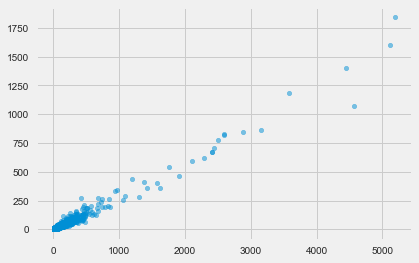

In [12]:
plt.scatter(df_temp['incidenti_week'],
            df_temp['incidenti_WE'],
            s=20,
            alpha=0.5)

In [13]:
df_temp['ratio'] = df_temp['incidenti_WE'] / df_temp['incidenti_week']
df_temp.sort_values(by='ratio',ascending=False).head()

,incidenti_week,incidenti_WE,ratio
Strada1,,,
VIA ISABELLA DI CASTIGLIA,1,10,10.0
VIA GIACOMO LAURENZANI,1,6,6.0
VIA GIUTURNA,1,5,5.0
PIAZZA BORGHESE,1,4,4.0
VICOLO DI VAL TELLINA,1,4,4.0


In [35]:
output_file("output/WE_vs_week.html")

source = ColumnDataSource(data=dict(
    x=df_temp[df_temp['incidenti_week']>100]['incidenti_week'].values,
    y=df_temp[df_temp['incidenti_week']>100]['incidenti_WE'].values,
    desc=[x.lower() for x in df_temp[df_temp['incidenti_week']>100].index.values]
))

hover = HoverTool(tooltips=[
    ("strada", "@desc"),
    ("incidenti settimanali", "$x{int}"),
    ("incidenti weekend", "$y{int}"),
    
])

p = figure(plot_width=600, plot_height=600, 
           #tools=[hover],
           title="Incidenti: durante la settimana vs. weekend")
p.add_tools(hover)
p.xaxis.axis_label = 'incidenti settimanali'
p.yaxis.axis_label = 'incidenti nel weekend'

p.circle('x', 'y', size=5, source=source)

print(embed.components(p)[1])
print(embed.components(p)[0])
#show(p)


<div class="bk-root">
    <div class="bk-plotdiv" id="7d978e93-236e-4ac6-abcb-4c50cd877cd1"></div>
</div>

<script type="text/javascript">
    (function() {
  var fn = function() {
    Bokeh.safely(function() {
      (function(root) {
        function embed_document(root) {
          var docs_json = {"772c0c5d-4a1d-4a75-941e-1d7fbed07e2a":{"roots":{"references":[{"attributes":{"callback":null},"id":"3d2f581e-3598-476a-9dee-ce46446850f2","type":"DataRange1d"},{"attributes":{},"id":"8b0e9973-54b7-4d11-a4e1-44868c54b022","type":"PanTool"},{"attributes":{"source":{"id":"c512acd4-0332-48ed-bc3e-e25c556c6874","type":"ColumnDataSource"}},"id":"63b64320-8d1d-4225-8e79-27169647387d","type":"CDSView"},{"attributes":{"axis_label":"incidenti nel weekend","formatter":{"id":"e08f2d3e-2340-416f-be1c-7aee947c3f29","type":"BasicTickFormatter"},"plot":{"id":"259b7ec3-f06b-41ce-bed4-ae89f1c1d946","subtype":"Figure","type":"Plot"},"ticker":{"id":"46c39d9a-6033-4398-b025-900c764ad25b","type":"BasicTicker"

# Incidenti con deceduti

In [26]:
df_temp = pd.merge(
        df[(df['DataOraIncidente_isweekend']==0) & (df.NUM_MORTI>0)].groupby('Strada1')\
                .count()[['ID']]\
                .rename(columns={'ID':'incidenti_week'}),
        df[(df['DataOraIncidente_isweekend']==1) & (df.NUM_MORTI>0)].groupby('Strada1')\
                .count()[['ID']]\
                .rename(columns={'ID':'incidenti_WE'}),
        left_index=True,
        right_index=True)

In [27]:
output_file("output/WE_vs_week--deceduti.html")

source = ColumnDataSource(data=dict(
    x=df_temp['incidenti_week'].values,
    y=df_temp['incidenti_WE'].values,
    desc=[x.lower() for x in df_temp.index.values]
))

hover = HoverTool(tooltips=[
    ("strada", "@desc"),
    ("incidenti settimanali", "$x{int}"),
    ("incidenti weekend", "$y{int}"),
    
])

p = figure(plot_width=600, plot_height=600, 
           #tools=[hover],
           title="Incidenti letali: durante la settimana vs. weekend")
p.add_tools(hover)
p.xaxis.axis_label = 'incidenti settimanali'
p.yaxis.axis_label = 'incidenti nel weekend'

p.circle('x', 'y', size=5, source=source)

show(p)